In [1]:
from PIL import Image
import numpy as np
import torch
from torch import Tensor
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from Algorithm import i_fgsm, fgsm
import util
%matplotlib inline

In [7]:
class Attack(object):
    def __init__(self, model):
        import pickle
        self.model = model.cuda()
        self.model.training = False
        self.model.transform_input = False
        self.model.eval()
        # get the number to label dictionary
        with open("ImageNet_label_dict.pb","rb") as f:
            self.dict = pickle.load(f)
        self.transform = transforms.Compose([
           transforms.Resize(255),
           transforms.CenterCrop(224),
           transforms.ToTensor()
        ])

        
    def perturb(self, img, Attack_method, steps=10, attack_target=0, eps = 0.001, alpha = 0.01, CrossEntropy=True):
        """
        img is the file path for image
        set attack_target = -1 for non targeted attack
        CrossEntropy=False switches to MSE for loss function
        """
        assert(type(attack_target)==int and attack_target>=-1 and attack_target<=999)
        img_pil = Image.open(img)
        x = self.transform(img_pil).unsqueeze_(0).cuda() # unsqueeze changes the shape from 3x244x244 to 1x3x244x244
        img_variable_cuda = x.clone()
        img_variable_cuda.requires_grad = True
        criterion = nn.CrossEntropyLoss() if CrossEntropy else nn.MSELoss()
        optimizer = optim.SGD([img_variable_cuda], lr=0.1, momentum=0.9)
        
        ####### show the original image prediction
        fc_out = self.model(x)
        real_target = fc_out.cpu().data.numpy().argmax()
        print("original prediction:", self.dict[real_target])
        ####### modify attacking direction accordingly, 
        ####### Change y to adapt to loss function(MSE takes onehot encoding, CrossEntropy uses number)
        y = util.one_hot(real_target) if attack_target==-1 else util.one_hot(attack_target)
        alpha = alpha if attack_target ==-1 else -1*alpha 
        y = y if type(criterion)==nn.modules.loss.MSELoss else y.argmax().unsqueeze_(0)
        ####### attacking
        img_variable_cuda=Attack_method(steps=steps, model=self.model, criterion=criterion, 
                                        Variable=img_variable_cuda, x=x, y=y, eps=eps, alpha=alpha)    
        ####### show the attack results
        fc_out = self.model(img_variable_cuda)
        print("attack prediction:", self.dict[fc_out.cpu().data.numpy().argmax()])
        ####### Plot two images
        util.show(x, img_variable_cuda)


In [3]:
resnet = models.resnet152(pretrained=True)

original prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
attack prediction: paper towel


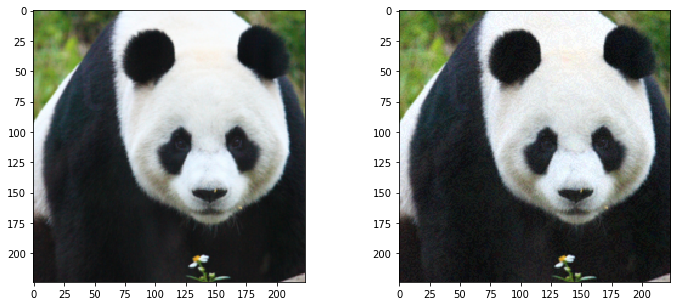

In [8]:
attack_resnet = Attack(resnet)
attack_resnet.perturb("panda.jpg", i_fgsm, steps=15, attack_target=-1, eps = 0.015, alpha = 1)

original prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
attack prediction: teddy, teddy bear


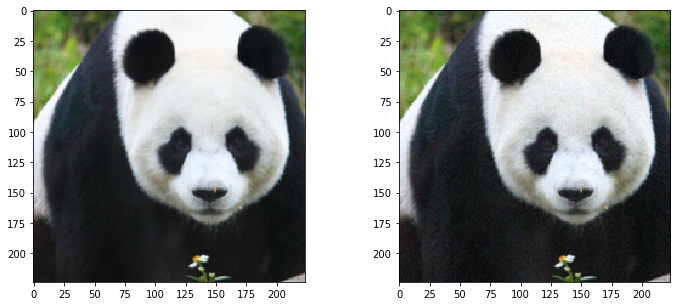

In [17]:
attack_resnet = Attack(resnet)
attack_resnet.perturb("panda.jpg", fgsm, steps=1, attack_target=-1, eps = 0.015, alpha = 1)